In [115]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from copy import deepcopy
import math

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB

#Ej 5
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [110]:
#Grafico la prediccion de una red
def graficar_nn(x, y, colname, title):
    df = pd.DataFrame(x)
    df['Clase'] = y
    df.plot(x=0, y=1, kind='scatter', c=colname, colormap='jet', title=title) #este grafico no superpone como el plt plot

def graficar_errores_contra_Vector(e_train, e_val, e_test, vectorX, title):
    plt.title(title)
    plt.plot(vectorX, e_train, label="train", linestyle=":")
    plt.plot(vectorX, e_val, label="validacion", linestyle="-.")
    plt.plot(vectorX, e_test, label="test", linestyle="-")
    plt.legend()
    plt.show()

  

### EJERCICIO 1 NB: DIMENSIONALIDAD
Podemos ver que nuestro modelo bayesiano hasta ahora viene siendo el que mejor resuelve el problema comparado directamente con los anteriores practicos. Técnicamente no observamos un overfitting grosero, a partir aproximadamente de la dimension 10 se empieza a notar. Pienso que esta notable mejoria de la resolucion del modelo se debe que el naive bayes de este ej es un gaussian bayes por lo que asume una distribucion inicial de probabilidades entre todos sus puntos como una campana cosa que comparte con el generador de puntos de las elipses. Además al usar una matrix de cov diagonal asegura la independencia de los puntos..... encaja de 11 el naive bayes.

###### Generadores

In [3]:
def gaussianClassesCovMatrixDiag (d,n, C):
    clase1Center = np.ones((d,), dtype=int)
    clase2Center = np.negative(clase1Center)
    devEst = (C*sqrt(d)) 
    cov = np.diag(np.full(d,devEst**2))

    puntosdata = []
    for i in range(n//2):
      vector = np.random.multivariate_normal(clase1Center, cov).tolist() + [1]
      puntosdata += [vector]

    for i in range(n//2):
      vector = np.random.multivariate_normal(clase2Center, cov).tolist() + [2]
      puntosdata += [vector]

    columnas = [("Coor"+ str(i+1)) for i in range(d)] 
    columnas.append("Clase")
    dataPunto = pd.DataFrame(puntosdata, columns = columnas)

    return dataPunto

def gaussianClassesCovMatrixDiagC (d,n, C):

    clase1Center = np.zeros((d,), dtype=int)
    clase1Center[0] = 1
    clase2Center = np.negative(clase1Center)

    devEst = C
    cov = np.diag(np.full(d,devEst**2))

    puntosdata = []
    for i in range(n//2):
      vector = np.random.multivariate_normal(clase1Center, cov).tolist() + [1]
      puntosdata += [vector]
    for i in range(n//2):
      vector = np.random.multivariate_normal(clase2Center, cov).tolist() + [2]
      puntosdata += [vector]
    columnas = [("Coor"+ str(i+1)) for i in range(d)] 
    columnas.append("Clase")
    dataPunto = pd.DataFrame(puntosdata, columns = columnas)

    return dataPunto

###### Dimensionalidad NB


In [24]:
def ej1():
    ErrorTestDiagonal = []
    ErrorTrainDiagonal = [] 
    ErrorTestParalelo = []
    ErrorTrainParalelo = []
    for d in [2 ** i for i in range(1, 6)]:
      x_col_names = ["Coor"+str(k) for k in range(1,d+1)]
      y_col_name = 'Clase'

      # Genero los conjuntos de test para cada d
      df_test_diag = gaussianClassesCovMatrixDiag(d, 10000, 0.78)
      df_test_para = gaussianClassesCovMatrixDiagC(d, 10000, 0.78)

      X_test_diag, y_test_diag = df_test_diag[x_col_names], df_test_diag[y_col_name]
      X_test_para, y_test_para = df_test_para[x_col_names], df_test_para[y_col_name]
      ErrorTestDiagonal_local = []
      ErrorTrainDiagonal_local = [] 
      ErrorTestParalelo_local = []
      ErrorTrainParalelo_local = []
      for i in range(20):
          # Genero los conjuntos de entrenamiento
          df_train_diag = gaussianClassesCovMatrixDiag(d, 250, 0.78)
          df_train_para = gaussianClassesCovMatrixDiagC(d, 250, 0.78)

          X_train_diag, y_train_diag = df_train_diag[x_col_names], df_train_diag[y_col_name]
          X_train_para, y_train_para = df_train_para[x_col_names], df_train_para[y_col_name]

          # Creo las redes neuronales
          clf_diag = GaussianNB()
          clf_para = GaussianNB()

          clf_diag.fit(X_train_diag, y_train_diag)
          clf_para.fit(X_train_para, y_train_para)

          predict_train_diag = clf_diag.predict(X_train_diag)
          predict_test_diag = clf_diag.predict(X_test_diag)
          predict_train_para = clf_para.predict(X_train_para)
          predict_test_para = clf_para.predict(X_test_para)

          actual_error_train_diag = 1 - accuracy_score(y_train_diag, predict_train_diag)
          actual_error_test_diag = 1 - accuracy_score(y_test_diag, predict_test_diag)  
          actual_error_train_para = 1 - accuracy_score(y_train_para, predict_train_para)
          actual_error_test_para = 1 - accuracy_score(y_test_para, predict_test_para)
            
          ErrorTrainDiagonal_local.append(actual_error_train_diag)
          ErrorTestDiagonal_local.append(actual_error_test_diag)
          ErrorTrainParalelo_local.append(actual_error_train_para)
          ErrorTestParalelo_local.append(actual_error_test_para)
        
      #Guardo prom
      ErrorTestDiagonal.append(np.mean(ErrorTestDiagonal_local))
      ErrorTrainDiagonal.append(np.mean(ErrorTrainDiagonal_local))
      ErrorTestParalelo.append(np.mean(ErrorTestParalelo_local))
      ErrorTrainParalelo.append(np.mean(ErrorTrainParalelo_local))

    error_df_diag = pd.DataFrame({})
    error_df_diag['d'] = [2 ** i for i in range(1, 6)]
    error_df_diag['Test Error'] = ErrorTestDiagonal
    error_df_diag['Train Error'] = ErrorTrainDiagonal

    error_df_paral = pd.DataFrame({})
    error_df_paral['d'] = [2 ** i for i in range(1, 6)]
    error_df_paral['Test Error'] = ErrorTestParalelo
    error_df_paral['Train Error'] = ErrorTrainParalelo
    
    return (error_df_diag, error_df_paral)


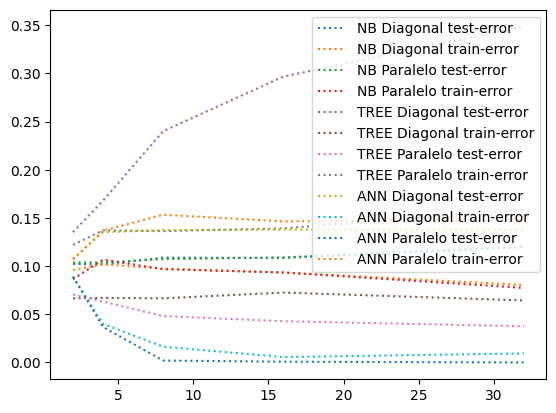

In [39]:
df_error_NB_diag, df_error_NB_paral = ej1()

ej1_errors_tree_df = pd.read_csv("tree_dimensions_errors.csv")
#_____DECODE importannt
trainTreeDiag = []
testTreeDiag = []
trainTreeParallel = []
testTreeParallel = []

for d in [2 ** i for i in range(1, 6)]:
    trainNPDiag = ej1_errors_tree_df[(ej1_errors_tree_df["Class"] == 'Tree - Train diagonal') & (ej1_errors_tree_df["d"] == d)]['Error'] .to_numpy()
    trainTreeDiag.append(np.mean(trainNPDiag))
    testNPDiag = ej1_errors_tree_df[(ej1_errors_tree_df["Class"] == 'Tree - Test diagonal') & (ej1_errors_tree_df["d"] == d)]['Error'] .to_numpy()
    testTreeDiag.append(np.mean(testNPDiag))
    trainNPParal = ej1_errors_tree_df[(ej1_errors_tree_df["Class"] == 'Tree - Train parallel') & (ej1_errors_tree_df["d"] == d)]['Error'] .to_numpy()
    trainTreeParallel.append(np.mean(trainNPParal))
    testNPParal = ej1_errors_tree_df[(ej1_errors_tree_df["Class"] == 'Tree - Test parallel') & (ej1_errors_tree_df["d"] == d)]['Error'] .to_numpy()
    testTreeParallel.append(np.mean(testNPParal))
#_____FIN_DECODE


ej1_errors_ann_df = pd.read_csv("ann_dimensions_errors.csv")

#_____DECODE
trainAnnDiag = []
testAnnDiag = []
trainAnnParallel = []
testAnnParallel = []

for d in [2 ** i for i in range(1, 6)]:
    trainNPDiag = ej1_errors_ann_df[(ej1_errors_ann_df["Class"] == 'ANN - Train diagonal') & (ej1_errors_ann_df["d"] == d)]['Error'] .to_numpy()
    trainAnnDiag.append(np.mean(trainNPDiag))
    testNPDiag = ej1_errors_ann_df[(ej1_errors_ann_df["Class"] == 'ANN - Test diagonal') & (ej1_errors_ann_df["d"] == d)]['Error'] .to_numpy()
    testAnnDiag.append(np.mean(testNPDiag))
    trainNPParal = ej1_errors_ann_df[(ej1_errors_ann_df["Class"] == 'ANN - Train parallel') & (ej1_errors_ann_df["d"] == d)]['Error'] .to_numpy()
    trainAnnParallel.append(np.mean(trainNPParal))
    testNPParal = ej1_errors_ann_df[(ej1_errors_ann_df["Class"] == 'ANN - Test parallel') & (ej1_errors_ann_df["d"] == d)]['Error'] .to_numpy()
    testAnnParallel.append(np.mean(testNPParal))
#_____FIN_DECODE

#Grafica del NB DIAGONAL
plt.plot(df_error_NB_diag['d'], df_error_NB_diag['Test Error'], label="NB Diagonal test-error", linestyle=":")
plt.plot(df_error_NB_diag['d'], df_error_NB_diag['Train Error'], label="NB Diagonal train-error", linestyle=":")
#Grafica del NB PARALELO
plt.plot(df_error_NB_paral['d'], df_error_NB_paral['Test Error'], label="NB Paralelo test-error", linestyle=":")
plt.plot(df_error_NB_paral['d'], df_error_NB_paral['Train Error'], label="NB Paralelo train-error", linestyle=":")

#Grafica del TREE DIAGONAL
plt.plot([2 ** i for i in range(1, 6)], testTreeDiag, label="TREE Diagonal test-error", linestyle=":")
plt.plot([2 ** i for i in range(1, 6)], trainTreeDiag, label="TREE Diagonal train-error", linestyle=":")
#Grafica del TREE PARALELO
plt.plot([2 ** i for i in range(1, 6)], trainTreeParallel, label="TREE Paralelo test-error", linestyle=":")
plt.plot([2 ** i for i in range(1, 6)], testTreeParallel, label="TREE Paralelo train-error", linestyle=":")

#Grafica del ANN DIAGONAL
plt.plot([2 ** i for i in range(1, 6)], testAnnDiag, label="ANN Diagonal test-error", linestyle=":")
plt.plot([2 ** i for i in range(1, 6)], trainAnnDiag, label="ANN Diagonal train-error", linestyle=":")
#Grafica del ANN PARALELO
plt.plot([2 ** i for i in range(1, 6)], trainAnnParallel, label="ANN Paralelo test-error", linestyle=":")
plt.plot([2 ** i for i in range(1, 6)], testAnnParallel, label="ANN Paralelo train-error", linestyle=":")

plt.legend()
plt.show()


### EJERCICIO 2 NB: Limites del Clasificador
Basicamente el naive bayes como la distribucion es gaussiana debe asumir que como al haber más puntos por fuera de las elipses para la misma altura en el plano es más problable que en esa región del plano "no" hay elipses. Las redes neuronales van por el otro lado aprendieron que en esa region horizontal del plano se van a encontrar las elipses.
En cuanto al analisis de las espirales si bien ambos resultados no son suficientes... podemos decir teoricamente que las espirales al ser generadas con una distribucion gaussiana y la forma de espiral en si misma hace que las clases esten perfectamente por así decirlo balanceadas en el plano por eso generalmente en los graficos del naive bayes va a intentar cortar por la mitad el plano en 2.

###### Generador de espirales

In [40]:
def SnailNestedSpiral(n):
    clase1 = []
    clase2 = []
    clasePuntos = []
    puntosC1 = 0
    puntosC2 = 0
    
    while puntosC1 < n//2 or puntosC2 < n//2 :
        ro = np.sqrt(np.random.uniform(low=0.0, high=1.0))
        phiCirc = np.random.uniform(low= 0.0, high= np.pi * 2)      
        x = ro * np.cos(phiCirc)
        y = ro * np.sin(phiCirc)
        if ((phiCirc) / (4*np.pi) < ro and ro < ((phiCirc)+np.pi) / (4*np.pi)) or ((phiCirc + 2*np.pi) / (4*np.pi) < ro and ro < ((phiCirc + 2*np.pi)+np.pi) / (4*np.pi)) or ((phiCirc - 2*np.pi) / (4*np.pi) < ro and ro < ((phiCirc- 2*np.pi)+np.pi) / (4*np.pi)):
            if(puntosC1 < n//2):
                clasePuntos.append([x,y, 1])
                puntosC1 += 1
        else:
            if( puntosC2 < n//2):
                clasePuntos.append([x,y, 2])
                puntosC2 += 1

    columnas = [("Coor"+ str(i+1)) for i in range(2)] #Hago una label para las columas sino queda feo
    columnas.append("Clase")
    dataPuntos =  pd.DataFrame(clasePuntos, columns = columnas) #Hago el dataFrame con los puntos de la clase1 y con la label
    return dataPuntos

###### Resolucion

In [72]:
def ej2A():
    # Leemos los datos del dataframe, sacamos los puntos de validation y train
    data_cols = ['Coor1', 'Coor2', 'Clase']
    data_df = pd.read_csv('dos_elipses.data',header=None, names=data_cols)

    # Separamos los datos, la validation y la train
    sample_df = data_df.sample(n = 500,random_state=1)
    dots_X_train, dots_X_validation, dots_y_train,dots_y_validation= train_test_split(sample_df.loc[:,["Coor1","Coor2"]], sample_df.loc[:,["Clase"]], train_size= 0.80, random_state=0)
    # Leemos el .test y separamos sus puntos
    test_data_df = pd.read_csv('dos_elipses.test',header=None, names=data_cols)
    # Separamos los datos, el test
    dots_X_test,dots_y_test = test_data_df.loc[:,["Coor1","Coor2"]], test_data_df.loc[:,["Clase"]]

    NBDosElipses = GaussianNB()
    NBDosElipses.fit(dots_X_train, dots_y_train.loc[:,"Clase"].to_numpy()) #Entrenar con un vector 1d
    predict_test = NBDosElipses.predict(dots_X_test)

    #Graficamos el predict NB
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],predict_test,"Clase","Gaussian NB Classifier 2 Elipses")
    #Graficamos el original
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],dots_y_test.loc[:,"Clase"],"Clase","Gaussian NB ORIGINAL Test")
    #Graficamos el ANN
    df_ann_predict = pd.read_csv("ann_predict.data") 
    #Si de color c le pongo una columna va a haber tantos colores distintos como elementos unicos de la columna
    graficar_nn(df_ann_predict.loc[:,["0","1"]],df_ann_predict.loc[:,["Class"]],"Clase","ANN Classifier 2 Elipses")


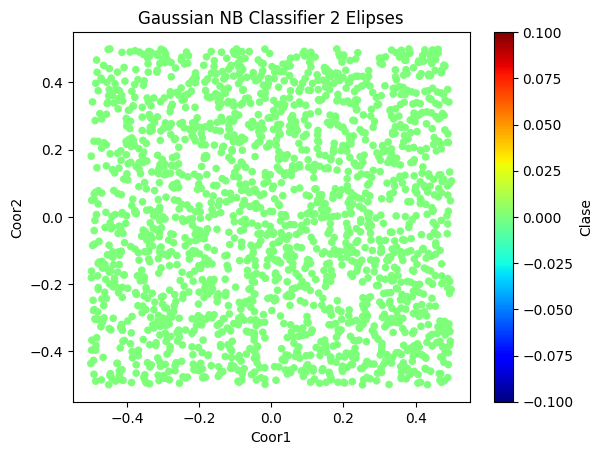

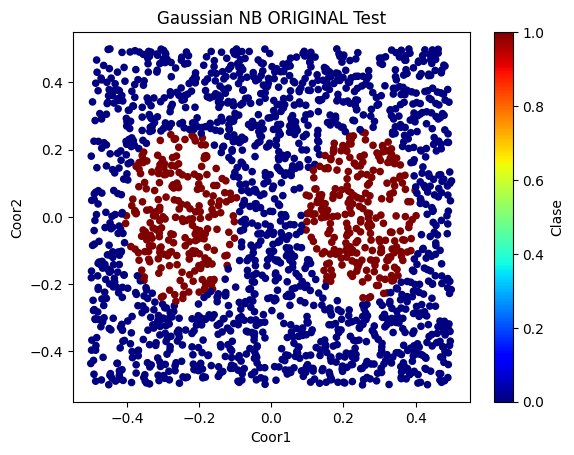

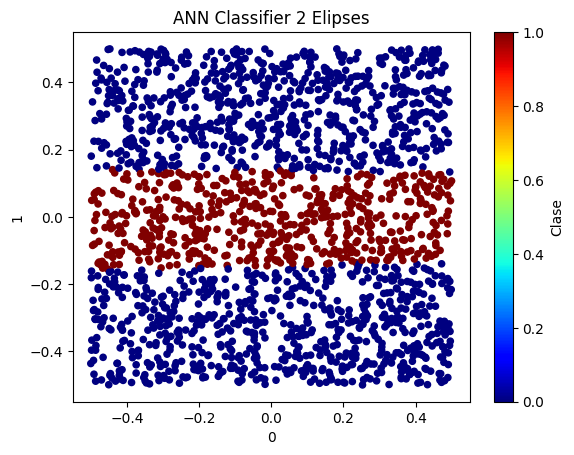

In [73]:
ej2A()

In [80]:
def ej2B():
    #Creamos el dataframe con los puntos
    dotsDF = SnailNestedSpiral(2600)
    #Separamos del dataframe las variables y su resultado
    dotsDFX, dotsDFY = dotsDF.loc[:,["Coor1","Coor2"]] , dotsDF.loc[:,["Clase"]]
    #Separamos el train del test
    dots_X_trainAndVal, dots_X_test, dots_y_trainAndVal, dots_y_test = train_test_split(dotsDFX, dotsDFY, train_size= 600, test_size = 2000)
    #Separamos el validation del train
    dots_X_train, dots_X_validation, dots_y_train, dots_y_validation = train_test_split(dots_X_trainAndVal, dots_y_trainAndVal,  test_size = 0.20)

    NBDosSpirals = GaussianNB()
    NBDosSpirals.fit(dots_X_train, dots_y_train.loc[:,"Clase"].to_numpy())

    predict_test = NBDosSpirals.predict(dots_X_test)

    #Graficamos el predict
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],predict_test,"Clase","Gaussian NB Classifier Spiral")
    #Graficamos el original
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],dots_y_test.loc[:,"Clase"],"Clase","Spiral Origina")
    #FALTA AGREGAR LAS NN 
    #Graficamos el ANN
    df_ann_predict = pd.read_csv("spirals_ann_predict.data") 
    #Si de color c le pongo una columna va a haber tantos colores distintos como elementos unicos de la columna
    graficar_nn(df_ann_predict.loc[:,["0","1"]],df_ann_predict.loc[:,["Class"]],"Clase","ANN Classifier Spiral")



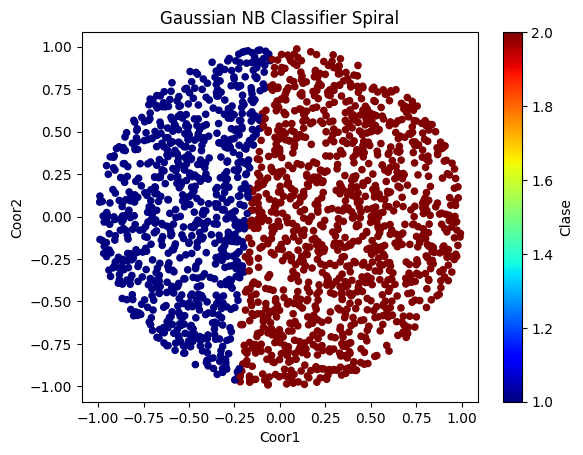

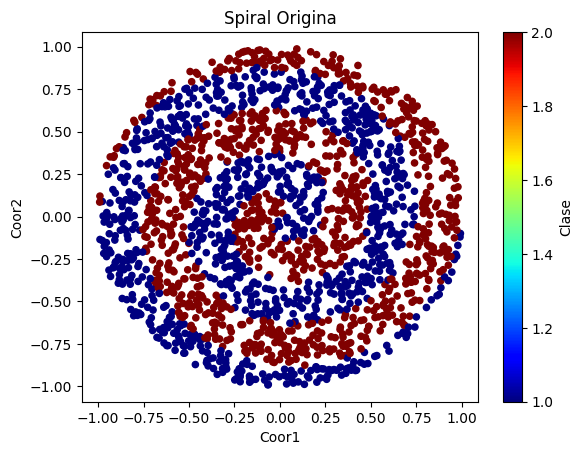

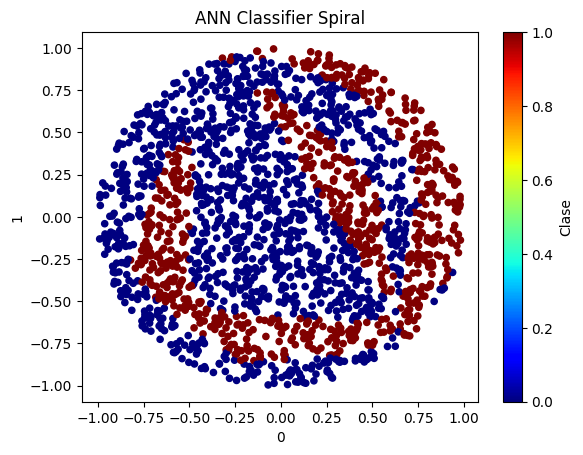

In [81]:
ej2B()

### Ejercicio 3 NB: Entrenamiento Histograma
Discretizando ando


In [105]:
def entrenar_NB_histograma(n_binds, X_train, y_train, X_val, y_val, X_test, y_test):
    NB_Best = None
    
    NB_error_Train_Best = None
    NB_error_Test_Best = None
    NB_error_Validation_Best = None
    NB_best_bins = None
    NB_best_kbdisc = None
    
    NB_e_train = []
    NB_e_val = []
    NB_e_test = []

    NB_current_error_train = 0.0
    NB_current_error_val = 0.0
    NB_current_error_test = 0.0

    for binds in n_binds: # Evaluaciones son las epocas de entrenamiento
        #Discretizando ando
        kbdisc = KBinsDiscretizer(n_bins=binds, encode='ordinal', strategy='uniform')
        kbdisc.fit(X_train)
        X_train_disc = kbdisc.transform(X_train.copy())
        X_val_disc = kbdisc.transform(X_val.copy())
        X_test_disc = kbdisc.transform(X_test.copy())

        #Acordate que el split train te devuelve DF por lo tanto como se entrena con LISTAS tengo que convertirlo lpm    
        NBDiscreto = CategoricalNB(min_categories=binds)
        NBDiscreto.fit(X_train_disc, y_train)

        predict_train = NBDiscreto.predict(X_train_disc)
        predict_val = NBDiscreto.predict(X_val_disc)
        predict_test= NBDiscreto.predict(X_test_disc)

        NB_current_error_train =  1 - accuracy_score(y_train, predict_train)
        NB_current_error_val = 1 - accuracy_score(y_val, predict_val)
        NB_current_error_test = 1 - accuracy_score(y_test, predict_test)

        #Guardamos el error para la epoca
        NB_e_train.append(NB_current_error_train)
        NB_e_val.append(NB_current_error_val)
        NB_e_test.append(NB_current_error_test)  

        #Reemplazo de valores de error, minificandolo en la validacion
        if NB_error_Validation_Best is None or NB_current_error_val < NB_error_Validation_Best :
            NB_error_Validation_Best = NB_current_error_val
            NB_error_Train_Best = NB_current_error_train
            NB_error_Test_Best = NB_current_error_test
            NB_best_bins = binds
            NB_best_kbdisc = deepcopy(kbdisc)
            NB_Best = deepcopy(NBDiscreto) # Copia de la NB entrenada para un bind especifico

    #Retornamos la mejor red y los errores para las "evaluaciones" cantidad de epocas
    return NB_Best, NB_e_train, NB_e_val, NB_e_test, NB_error_Train_Best,NB_error_Validation_Best, NB_error_Test_Best, NB_best_bins, NB_best_kbdisc

### Ejercicio 4 NB: Histograma dos-elipses y spiral
Notamos que a comparacion del ej2 notablemente es mejor. Sobre todo en el ejercicio(solamente) de las 2 elipses porque ahora aumentando la cantidad de binds tenemos más posibilidades de fragmentar el espacio en el clasificador, generalmente lo fraccionamos con bordes rectos. En cuando a las espirales essta division del espacio curvado es muy compleja, por lo tanto podemos verr como el naive bayes discreto fracciona el espacio como en cuadrantes y le asigna la clasificacion segun la cantidad de puntos que haya mayoria en su interior deformando asi las espirales

In [111]:
def ej4A():
   # Leemos los datos del dataframe, sacamos los puntos de validation y train
    data_cols = ['Coor1', 'Coor2', 'Clase']
    data_df = pd.read_csv('dos_elipses.data',header=None, names=data_cols)

    # Separamos los datos, la validation y la train
    sample_df = data_df.sample(n = 500,random_state=1)
    dots_X_train, dots_X_validation, dots_y_train,dots_y_validation= train_test_split(sample_df.loc[:,["Coor1","Coor2"]], sample_df.loc[:,["Clase"]], train_size= 0.80, random_state=0)
    # Leemos el .test y separamos sus puntos
    test_data_df = pd.read_csv('dos_elipses.test',header=None, names=data_cols)
    # Separamos los datos, el test
    dots_X_test,dots_y_test = test_data_df.loc[:,["Coor1","Coor2"]], test_data_df.loc[:,["Clase"]]
#__________
    n_binds = range(4, 102, 2)
    NB_Best, NB_e_train, NB_e_val, NB_e_test, NB_error_Train_Best,NB_error_Validation_Best, NB_error_Test_Best, NB_best_bins, NB_best_kbdisc = entrenar_NB_histograma(n_binds, dots_X_train, dots_y_train.loc[:,"Clase"].to_numpy(), dots_X_validation, dots_y_validation, dots_X_test, dots_y_test)
#__________
    graficar_errores_contra_Vector( NB_e_train, NB_e_val, NB_e_test, n_binds, "Error x Bins")
#__________
    X_test_disc = NB_best_kbdisc.transform(dots_X_test.copy())
    predict_test = NB_Best.predict(X_test_disc)

    #graficamos el predict
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],predict_test,"Clase","Categorical NB Classifier with {0} bins".format(NB_best_bins))
    #Graficamos el original
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],dots_y_test.loc[:,"Clase"],"Clase","Original 2 Elipses Data")


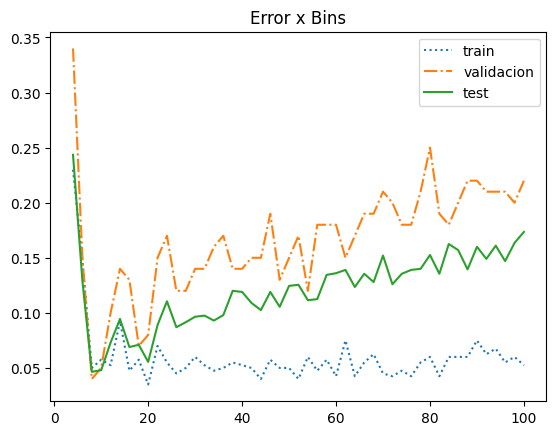

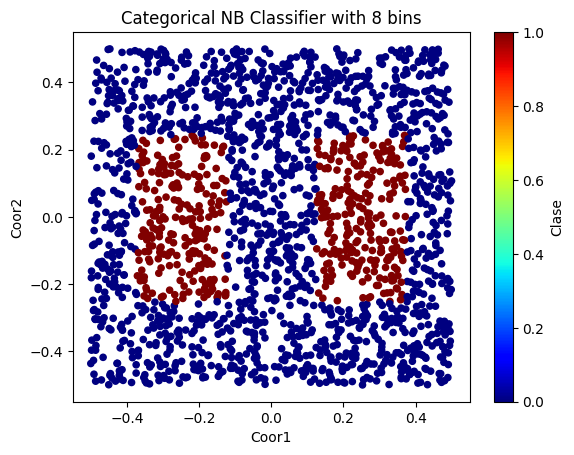

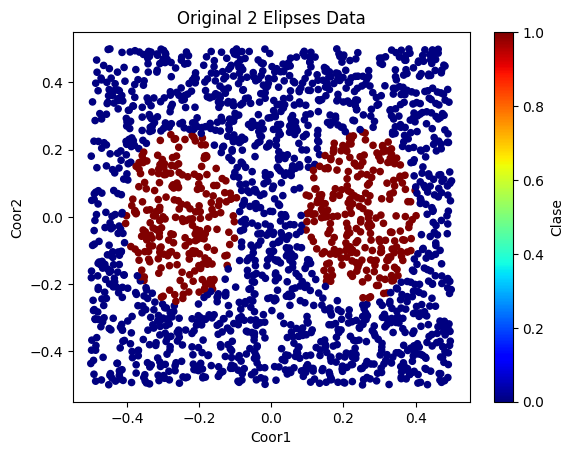

In [112]:
ej4A()

In [113]:
def ej4B():
    #Creamos el dataframe con los puntos
    dotsDF = SnailNestedSpiral(2600)
    #Separamos del dataframe las variables y su resultado
    dotsDFX, dotsDFY = dotsDF.loc[:,["Coor1","Coor2"]] , dotsDF.loc[:,["Clase"]]
    #Separamos el train del test
    dots_X_trainAndVal, dots_X_test, dots_y_trainAndVal, dots_y_test = train_test_split(dotsDFX, dotsDFY, train_size= 600, test_size = 2000)
    #Separamos el validation del train
    dots_X_train, dots_X_validation, dots_y_train, dots_y_validation = train_test_split(dots_X_trainAndVal, dots_y_trainAndVal,  test_size = 0.20)

    n_bins = range(10, 202, 2)
    NB_Best, NB_e_train, NB_e_val, NB_e_test, NB_error_Train_Best,NB_error_Validation_Best, NB_error_Test_Best, NB_best_bins, NB_best_kbdisc = entrenar_NB_histograma(n_bins, dots_X_train, dots_y_train.loc[:,"Clase"].to_numpy(), dots_X_validation, dots_y_validation, dots_X_test, dots_y_test)
#__________
    graficar_errores_contra_Vector( NB_e_train, NB_e_val, NB_e_test, n_bins, "Error x Bins")
#__________
    X_test_disc = NB_best_kbdisc.transform(dots_X_test.copy())
    predict_test = NB_Best.predict(X_test_disc)
     
    #graficamos el predict
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],predict_test,"Clase","Categorical NB Classifier with {0} bins".format(NB_best_bins))
    #Graficamos el original
    graficar_nn(dots_X_test.loc[:,["Coor1","Coor2"]],dots_y_test.loc[:,"Clase"],"Clase","Categorical NB ORIGINAL Test")



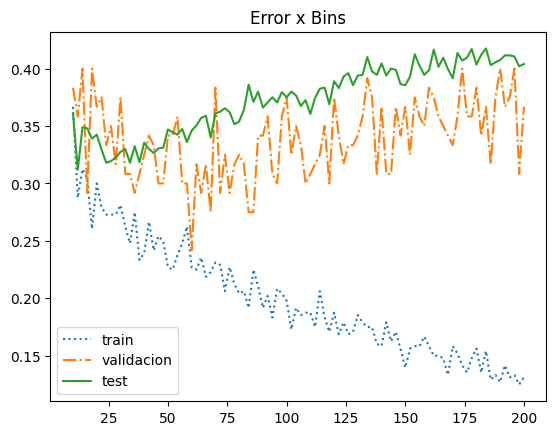

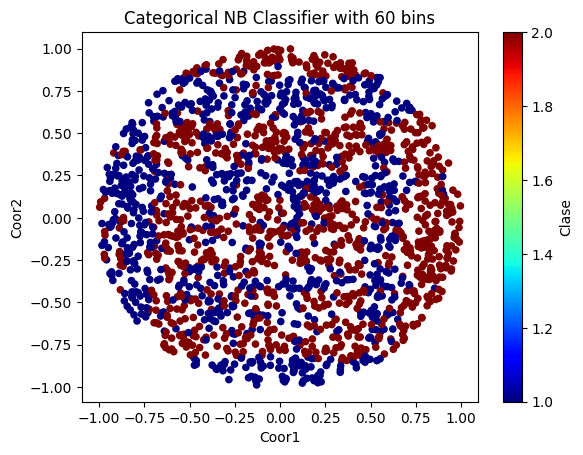

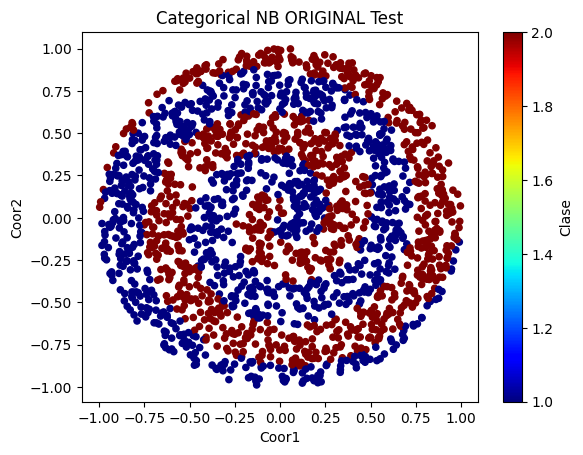

In [114]:
ej4B()

### Ejercicio 5 NB: Multinomial
Ya desde el vamos notamos que hay una buena densidad de hits en la diagonal de la matrix de confusion. Podemos decir que con un diccionario mas pequeño aumenta el error porque la clasificacion de los tópicos es más general, inversamente lo que pasa con los diccionarios grandes donde podemos adentrarnos mejor y poder identificar entre subtopicos y más. Increíblemente a partir del largo 4000 y 6000 uno se espera a priori un posible sobreajuste en el modelo. Pero aún así notamos que aunque la mayor hit fue sobre la diagonal tenemos como la de la clase 3 que el clasificador le erra, debe ser porque deben ser topicos parecidos derivado del uso muy parecido de las palabras. Generalizndo un poco el clasificador en la masa del medio la clasificacion es muy buena, pero al comienzo y final pistea un poco. Puede ser que radique en que el comienzo por ahí los topicos son generales y pocos profundos o introductorios, y al final por ahí son a forma de conclusion usando referencias a topicos anteriores


In [116]:
def ej5():
  X, y = fetch_20newsgroups(subset="train",return_X_y=True, remove=["headers"])
  X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
  X_test, y_test = fetch_20newsgroups(subset="test",return_X_y=True,remove=["headers"])

  best_val_error = math.inf
  table = []

  for largo_diccionario in [400, 1000, 2500, 4000, 6000, 10000]:
    for alfa in [10 ** i for i in range(-5, 1)]:
      vec = CountVectorizer(stop_words='english',max_features=largo_diccionario)
      Xvec_train = vec.fit_transform(X_train).toarray()
      Xvec_val = vec.transform(X_val).toarray()
      Xvec_test = vec.transform(X_test).toarray()

      clf = MultinomialNB(alpha=alfa)
      clf.fit(Xvec_train, y_train)

      predict_train = clf.predict(Xvec_train)
      predict_val = clf.predict(Xvec_val)
      predict_test = clf.predict(Xvec_test)

      actual_train_error = 1 - accuracy_score(y_train, predict_train)
      actual_val_error = 1 - accuracy_score(y_val, predict_val)
      actual_test_error = 1 - accuracy_score(y_test, predict_test)
      
      table.append([largo_diccionario, alfa, actual_train_error, actual_val_error, actual_test_error])

      if actual_val_error < best_val_error:
        best_val_error = actual_val_error
        best_largo = largo_diccionario
        best_alfa = alfa
        best_predict_test = deepcopy(predict_test)

  print("Mejor largo de diccionario: {0} mejor alfa: {1}".format(best_largo, best_alfa, best_val_error))
  table_df = pd.DataFrame(table, columns = ["Largo de diccionario", "Alfa", "Train error", "Validation error", "Test error"])
  display(table_df)

  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(y_test, best_predict_test, display_labels=clf.classes_, ax=ax)
  plt.show()

Mejor largo de diccionario: 10000 mejor alfa: 0.01


,Largo de diccionario,Alfa,Train error,Validation error,Test error
0,400,0.00001,0.405539,0.474019,0.534519
1,400,0.00010,0.406011,0.474019,0.534121
2,400,0.00100,0.406718,0.472959,0.534121
3,400,0.01000,0.407543,0.472959,0.533723
4,400,0.10000,0.409193,0.475080,0.533457
5,400,1.00000,0.415793,0.479675,0.534519
6,1000,0.00001,0.259988,0.355249,0.417817
7,1000,0.00010,0.260577,0.349947,0.413436
8,1000,0.00100,0.261874,0.346766,0.410913
9,1000,0.01000,0.263642,0.346766,0.407329


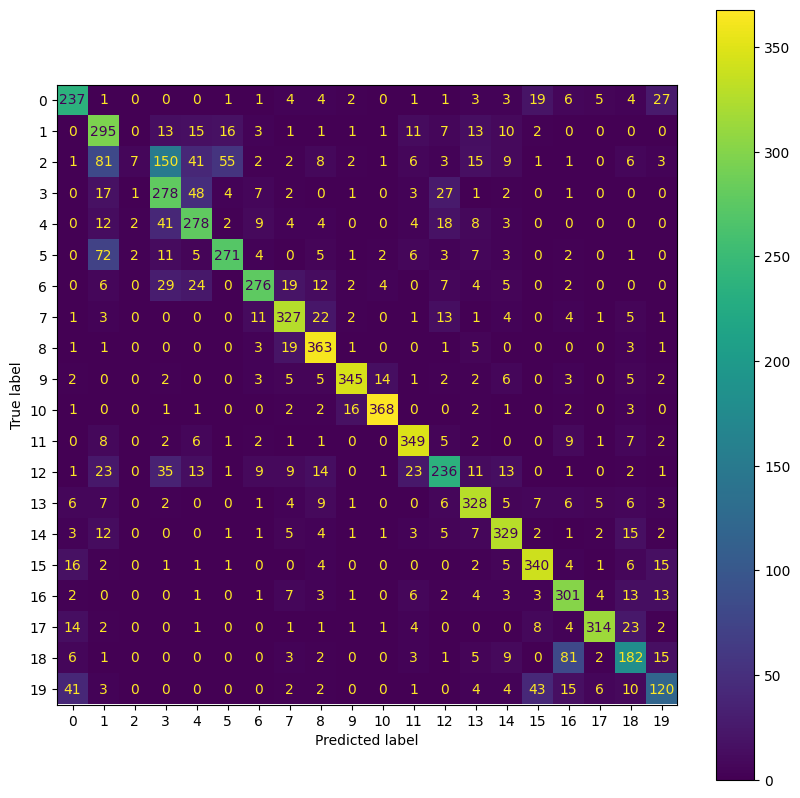

In [117]:
ej5()

### Ejercicio 6 NB: Non Naive Bayes

In [ ]:
from sklearn import preprocessing

class LessNaiveBayes():

    def _set_prior(self, y):
        self.prior=[[ 1 / len(np.unique(y)),classe] for classe in np.unique(y)]#np.full(len(np.unique(y)), 1 / len(np.unique(y)))
        #print(self.prior)
        #self.prior = Pmf(1 / len(np.unique(y)), np.unique(y))

    def _set_feature_names(self, X):
        self.FEATURE_NAMES = [f"x_{i}" for i in range(X.shape[1])]

    def _update(self, feature_value):
        classes = [cls for (prob,cls) in self.prior]#self.prior.qs
        likelihood = [self.multi_normals[cls].pdf(feature_value) for cls in classes]
        posterior = [[self.prior[i][0]*likelihood[i],self.prior[i][1]] for i in range(0,len(classes))]#self.prior * likelihood
        #posterior.normalize()preprocessing.normalize([x_array])
        #normaliza2 = preprocessing.normalize([[a for [a,c] in posterior]])
        #posterior = [[normaliza2[0][i],self.prior[i][1]] for i in range(0,len(classes))]
        return np.array(posterior)

    def _define_multi_normals(self, X, y):
        df = pd.DataFrame(
            np.hstack([y.reshape(-1, 1), X]),
            columns=["y"] + self.FEATURE_NAMES
        )
        self.multi_normals = df.groupby("y").apply(
            lambda group: multivariate_normal(
                group[self.FEATURE_NAMES].mean(),
                group[self.FEATURE_NAMES].cov()
            )
        ).to_dict()

    def fit(self, X, y):
        self._set_feature_names(X)
        self._set_prior(y)
        self._define_multi_normals(X, y)

    def predict_proba(self, X):
        y_pred = []
        for row_id in range(X.shape[0]):
            features = X[row_id, :]
            posterior = self._update(features)
            y_pred.append(posterior.reshape(1, -1))
        return np.vstack(y_pred)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [ ]:
from scipy.stats import multivariate_normal


def ej6():


 #     #Creamos el dataframe con los puntos
 #     dotsDF = SnailNestedSpiral(2600)
 #     #Separamos del dataframe las variables y su resultado
 #     dotsDFX, dotsDFY = dotsDF.loc[:,["Coor1","Coor2"]] , dotsDF.loc[:,["Clase"]]
 #     #Separamos el train del test
 #     dots_X_trainAndVal, dots_X_test, dots_y_trainAndVal, dots_y_test = train_test_split(dotsDFX, dotsDFY, train_size= 600, test_size = 2000)
 #     #Separamos el validation del train
 #     dots_X_train, dots_X_validation, dots_y_train, dots_y_validation = train_test_split(dots_X_trainAndVal, dots_y_trainAndVal,  test_size = 0.20)

  # Leemos los datos del dataframe, sacamos los puntos de validation y train
    data_cols = ['Coor1', 'Coor2', 'Clase']
    data_df = pd.read_csv('dos_elipses.data',header=None, names=data_cols)

      # Separamos los datos, la validation y la train
    sample_df = data_df.sample(n = 500,random_state=1)
    dots_X_train, dots_X_validation, dots_y_train,dots_y_validation= train_test_split(sample_df.loc[:,["Coor1","Coor2"]], sample_df.loc[:,["Clase"]], train_size= 0.80, random_state=0)
      # Leemos el .test y separamos sus puntos
    test_data_df = pd.read_csv('dos_elipses.test',header=None, names=data_cols)
      # Separamos los datos, el test
    dots_X_test,dots_y_test = test_data_df.loc[:,["Coor1","Coor2"]], test_data_df.loc[:,["Clase"]]


    nonNaiveBayes = LessNaiveBayes()
    nonNaiveBayes.fit(dots_X_train,dots_y_train.values)

    y_proba = nonNaiveBayes.predict_proba(dots_X_test.values)
    y_pred = nonNaiveBayes.predict(dots_X_test.values)

    print(y_pred)
    print(y_proba)

In [ ]:
ej6()

[3 3 3 ... 3 3 3]
[[0.54383531 0.         0.7554434  1.        ]
 [0.6022193  0.         0.70804769 1.        ]
 [0.49482929 0.         0.69087001 1.        ]
 ...
 [0.17588926 0.         0.00325688 1.        ]
 [0.37273282 0.         0.06060904 1.        ]
 [0.1260006  0.         0.0014413  1.        ]]
